Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from glob import glob

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )##todo

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )##todo


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

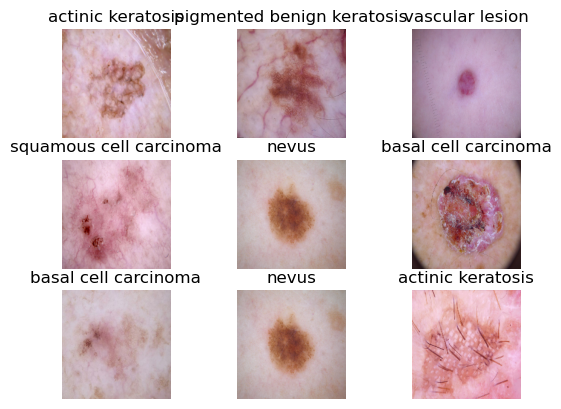

In [11]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

C:\Users\jehan\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 363ms/step - accuracy: 0.2011 - loss: 2.1383 - val_accuracy: 0.4477 - val_loss: 1.4652
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - accuracy: 0.4525 - loss: 1.4397 - val_accuracy: 0.5145 - val_loss: 1.2767
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - accuracy: 0.5331 - loss: 1.2499 - val_accuracy: 0.5932 - val_loss: 1.1069
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 285ms/step - accuracy: 0.6138 - loss: 1.0655 - val_accuracy: 0.6162 - val_loss: 1.0193
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - accuracy: 0.6694 - loss: 0.8921 - val_accuracy: 0.6481 - val_loss: 0.9726
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 422ms/step - accuracy: 0.7236 - loss: 0.7649 - val_accuracy: 0.6897 - val_loss: 0.9131
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.7730 - loss: 0.6394 - val_accuracy: 0.6563 - val_loss: 0.9610
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - accuracy: 0.7964 - loss: 0

### Visualizing training results

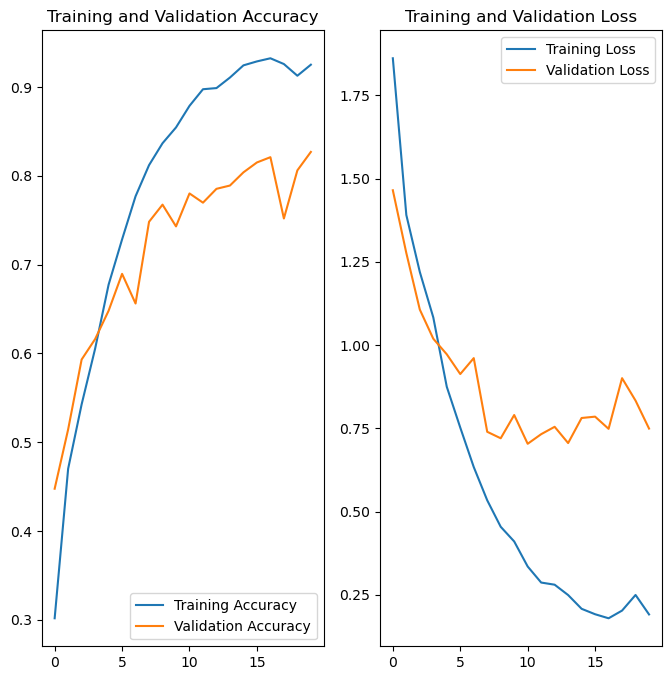

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
<h2>Findings:-</h2>
<p style="font-size:18px"> The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset. <br/> 
   &nbsp;&nbsp; (1) Training accuracy is very high, while validation accuracy is around 50%. <br/> 
   &nbsp;&nbsp; (2) The loss on the training set decreases after each epoch, but in the case of the validation set, it climbs back again after the 5th epoch. <br/>
    <br/>
Instead of generalizing and learning real features and general relationships, the model memorized the data</p>

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images
    layers.RandomRotation(0.2),                   # Randomly rotate images
    layers.RandomZoom(height_factor=0.2, width_factor=0.2)  # Randomly zoom images
])


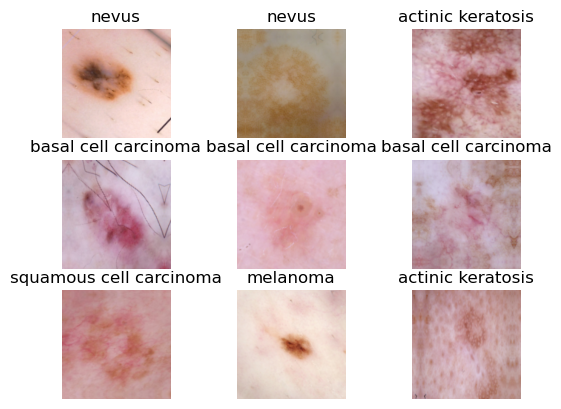

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

### Compiling the model

In [21]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 395ms/step - accuracy: 0.1415 - loss: 2.3105 - val_accuracy: 0.3586 - val_loss: 1.7276
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.3022 - loss: 1.8528 - val_accuracy: 0.4395 - val_loss: 1.5399
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - accuracy: 0.3922 - loss: 1.5659 - val_accuracy: 0.4670 - val_loss: 1.4135
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - accuracy: 0.4157 - loss: 1.5150 - val_accuracy: 0.4781 - val_loss: 1.3327
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 335ms/step - accuracy: 0.4599 - loss: 1.4056 - val_accuracy: 0.4157 - val_loss: 1.5150
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.4564 - loss: 1.4165 - val_accuracy: 0.4633 - val_loss: 1.3357
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 368ms/step - accuracy: 0.4727 - loss: 1.3617 - val_accuracy: 0.4484 - val_loss: 1.4884
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 354ms/step - accuracy: 0.4759 - loss: 1

### Visualizing the results

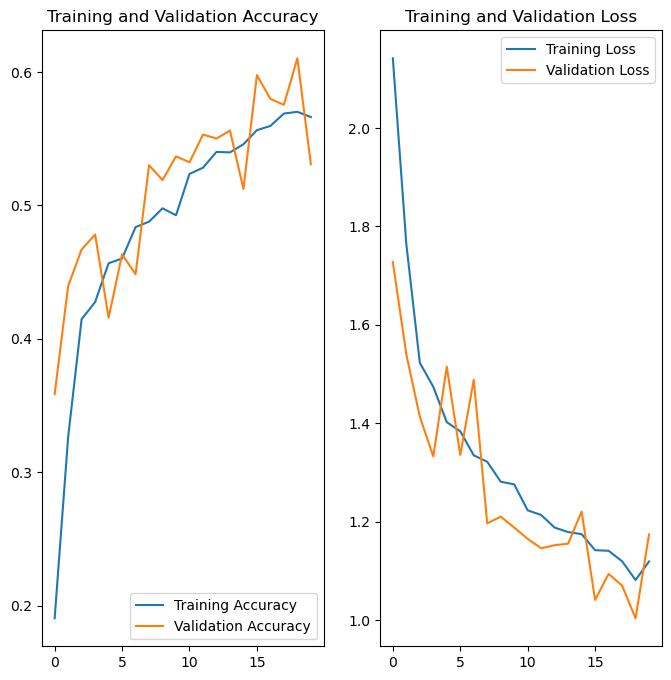

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
<h2>Findings:-</h2>
<p style="font-size:18px"> In the above model use of data augmentation and dropout layer reduced the problem of overfitting. <br/>
    <br/>The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. The loss function is synchronously exhausted for the training and validation data.</p>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [25]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


<BarContainer object of 9 artists>

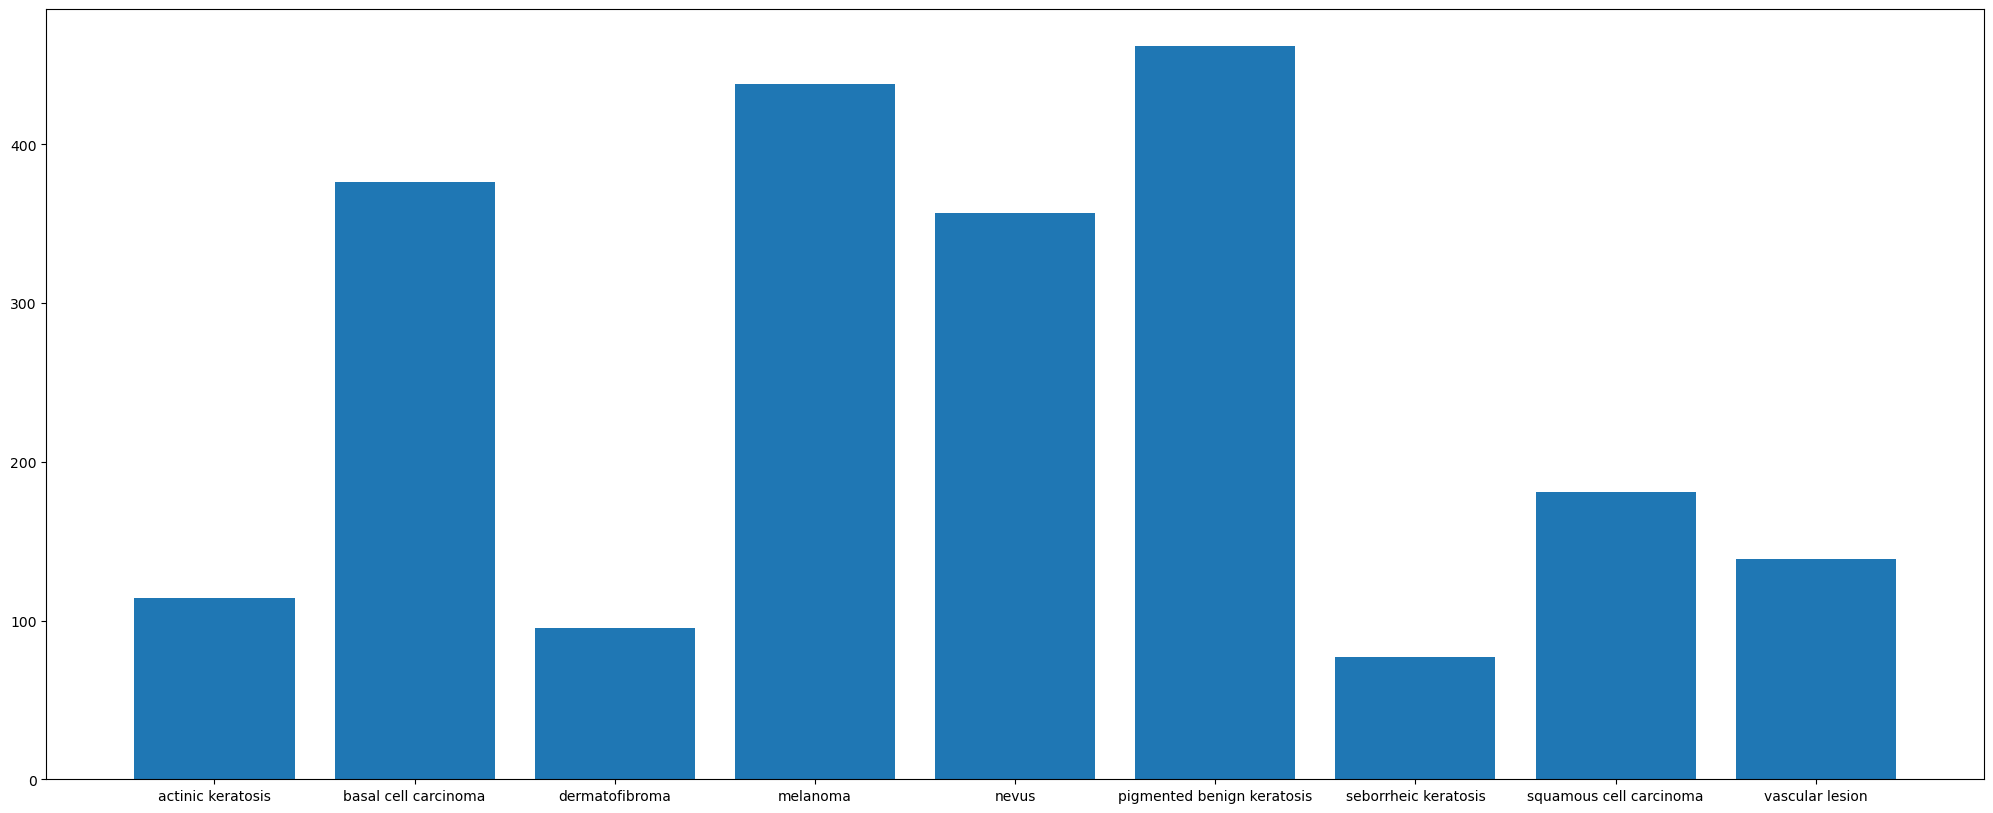

In [26]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
<p syle="size:18px">The least number of samples are in seborrheic keratosis</p>

#### - Which classes dominate the data in terms proportionate number of samples?
<p syle="size:18px">The classes dominate in the data are:- 
<br/> * pigmented benign
<br/> * melanoma
<br/>* basal cell carcinoma
<br/>* nevus</p>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset='Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A2C7CD4320>: 100%|██████████| 500/500 [00:02<00:00, 191.79 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A2AE40F320>: 100%|██████████| 500/500 [00:02<00:00, 196.32 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A2B4BDC1A0>: 100%|██████████| 500/500 [00:02<00:00, 198.15 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1A2BD4DC260>: 100%|██████████| 500/500 [00:13<00:00, 37.83 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1A2BCFD20F0>: 100%|██████████| 500/500 [00:10<00:00, 49.84 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1A2C7CE0AA0>: 100%|██████████| 500/500 [00:02<00:00, 208.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A2BD3C4CB0>: 100%|██████████| 500/500 [00:04<00:00, 101.96 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A2D9C61640>: 100%|██████████| 500/500 [00:02<00:00, 228.28 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A3C2F241A0>: 100%|██████████| 500/500 [00:02<00:00, 232.25 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0dd511ce-ef47-46ec-8e1f-841cf882adfe.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3df085e3-8315-4644-b9e1-ad8df2be5b3e.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9aca45ea-5380-49c1-84e5-4216222c8526.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a8d10754-a380-4e07-bdac-7d6417b621b3.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_fdd3c77a-0f0a-4b69-b7af-4c28d7f62905.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_491e8283-b2a3-45af-9417-81eda738de33.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_74faa8a8-aff0-4379-9d18-4b6066898d28.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b9f3094c-ada3-47ae-b931-ac268732cb98.jpg',
 'Train\\actinic

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
# 'train/class_name/output/221tews.jpg'.split('/')[-3]

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
import pandas as pd

df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)  # Use pd.concat to combine DataFrames


In [35]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 111s 377ms/step - accuracy: 0.2381 - loss: 1.9705 - val_accuracy: 0.4410 - val_loss: 1.4591
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 109s 386ms/step - accuracy: 0.4201 - loss: 1.4950 - val_accuracy: 0.4860 - val_loss: 1.3160
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 102s 363ms/step - accuracy: 0.4661 - loss: 1.3707 - val_accuracy: 0.4686 - val_loss: 1.3272
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 98s 348ms/step - accuracy: 0.4830 - loss: 1.3377 - val_accuracy: 0.5105 - val_loss: 1.2810
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 94s 333ms/step - accuracy: 0.4999 - loss: 1.2845 - val_accuracy: 0.5278 - val_loss: 1.2102
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 95s 339ms/step - accuracy: 0.4960 - loss: 1.2661 - val_accuracy: 0.5407 - val_loss: 1.1667
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 94s 334ms/step - accuracy: 0.5131 - loss: 1.2447 - val_accuracy: 0.5274 - val_loss: 1.2630
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 93s 331ms/step - accuracy: 0.5342 - loss

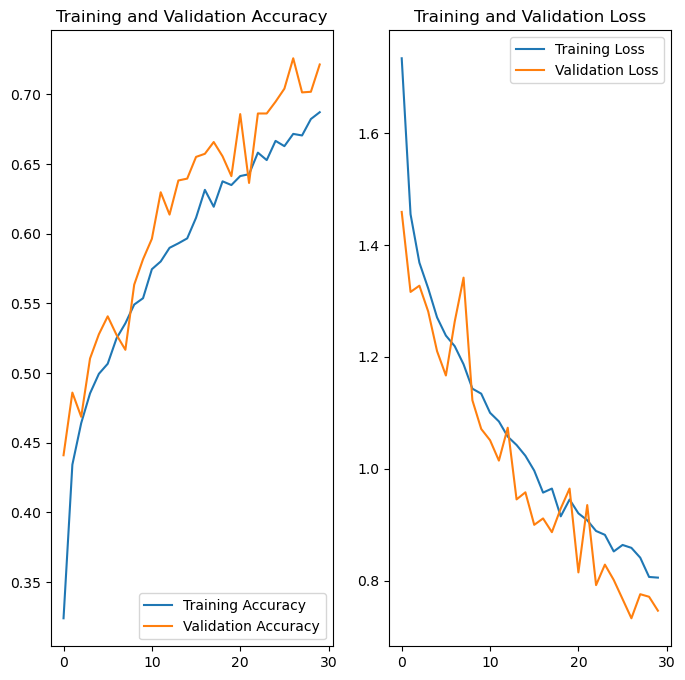

In [42]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
The problem of overfitting and underfitting was solved and the model was well trained for predictions. Data augmentation, outliers, and class equalization were found to be useful in improving model performance in this case.


#### Train your model for 20 more epochs

In [43]:
epochs = 20
## Your code goes here, use 30 epochs.
history20 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 108s 386ms/step - accuracy: 0.6942 - loss: 0.7815 - val_accuracy: 0.7294 - val_loss: 0.7032
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 109s 388ms/step - accuracy: 0.7013 - loss: 0.7708 - val_accuracy: 0.7330 - val_loss: 0.7194
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 110s 392ms/step - accuracy: 0.6825 - loss: 0.8092 - val_accuracy: 0.7089 - val_loss: 0.7914
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 108s 386ms/step - accuracy: 0.6900 - loss: 0.8013 - val_accuracy: 0.7499 - val_loss: 0.6627
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 111s 394ms/step - accuracy: 0.7125 - loss: 0.7532 - val_accuracy: 0.7419 - val_loss: 0.6689
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 109s 387ms/step - accuracy: 0.6916 - loss: 0.8126 - val_accuracy: 0.7508 - val_loss: 0.6796
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 109s 387ms/step - accuracy: 0.7168 - loss: 0.7272 - val_accuracy: 0.7316 - val_loss: 0.6971
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 110s 390ms/step - accuracy: 0.7201 -

#### Visualize the model results for 20 more epochs

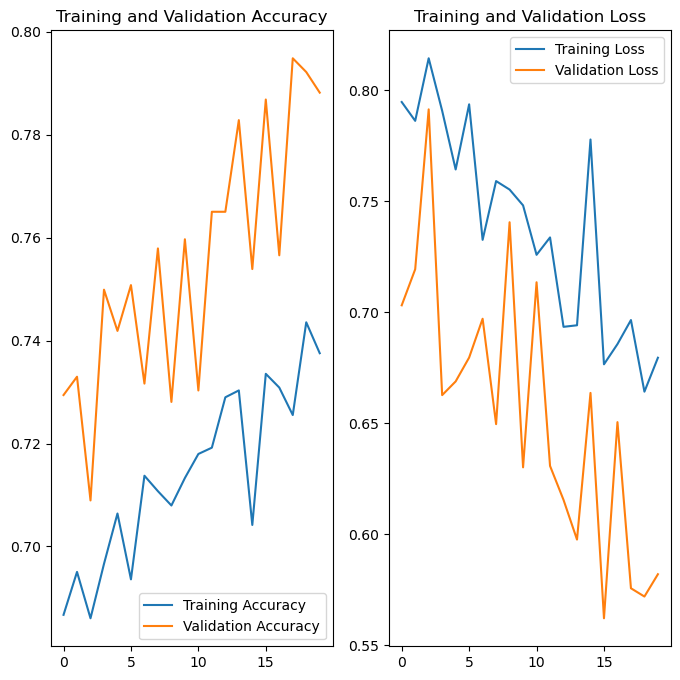

In [44]:
acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']

loss = history20.history['loss']
val_loss = history20.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Train your model for 50 more epochs

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 110s 392ms/step - accuracy: 0.7455 - loss: 0.6482 - val_accuracy: 0.7784 - val_loss: 0.5924
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 110s 391ms/step - accuracy: 0.7310 - loss: 0.6954 - val_accuracy: 0.8028 - val_loss: 0.5480
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 107s 381ms/step - accuracy: 0.7387 - loss: 0.6793 - val_accuracy: 0.7842 - val_loss: 0.5651
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 105s 372ms/step - accuracy: 0.7536 - loss: 0.6469 - val_accuracy: 0.7944 - val_loss: 0.5456
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 106s 378ms/step - accuracy: 0.7583 - loss: 0.6291 - val_accuracy: 0.8122 - val_loss: 0.5220
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 106s 375ms/step - accuracy: 0.7480 - loss: 0.6536 - val_accuracy: 0.7819 - val_loss: 0.5828
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 105s 374ms/step - accuracy: 0.7557 - loss: 0.6329 - val_accuracy: 0.7717 - val_loss: 0.5990
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 105s 375ms/step - accuracy: 0.7527 -

####  Visualize the model results for 50 more epochs

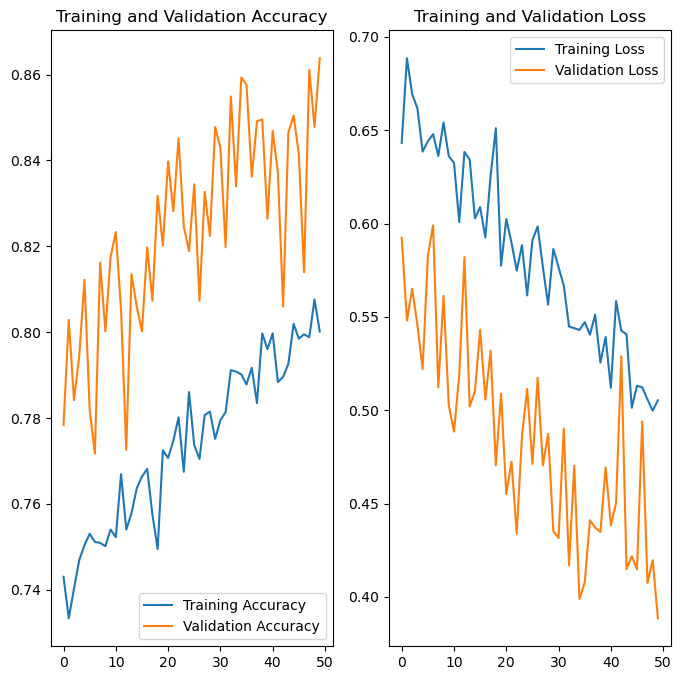

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()